# Hyperparemeter optimization of networks to predict wpm


## Set up


In [1]:
# Building on the basic pytorch model in nn-predict.ipynb, develop ML pipeline with 
# hyperparameter optimization
# See https://appsilon.com/pytorch-neural-network-tutorial/ for a simple example

# Set up to use local modules
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.insert(0, module_path)

In [2]:
import time
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval
from sklearn.metrics import root_mean_squared_error

from src import process
from src import models
from src import plot

# Load the CSV file results.csv into a dataframe and add some processed columns
df = process.load_processed_results()
# display(df.head())
# display(df.tail())

## Train network


In [3]:
# Prepare data

# Include trial types above a certain threshold of occurances
min_trial_count = 100
combined_id_value_counts = df["combined_id"].value_counts()
combined_id_value_counts = combined_id_value_counts[
    combined_id_value_counts >= min_trial_count
]

valid_trial_ids = combined_id_value_counts.index.tolist()
feature_cols = ["combined_id", "acc", "trial_num", "trial_type_num"]
target_col = ["wpm"]

X_df = df.loc[
    df["combined_id"].isin(valid_trial_ids),
    feature_cols,
]
Y_df = df[df["combined_id"].isin(valid_trial_ids)][target_col]

# Convert X_df['combined_id'] to a 1-hot encoding
X_df = pd.get_dummies(X_df, columns=["combined_id"]).astype(int)

display(X_df.head())
display(Y_df.head())

,acc,trial_num,trial_type_num,combined_id_2,combined_id_17,combined_id_25,combined_id_29,combined_id_34
5,91,6,1,1,0,0,0,0
6,95,7,2,1,0,0,0,0
7,93,8,3,1,0,0,0,0
8,93,9,4,1,0,0,0,0
9,90,10,5,1,0,0,0,0


,wpm
5,52.39
6,64.39
7,57.79
8,58.39
9,53.79


In [4]:
# Parameters
params = models.get_default_params()

seed = 42
torch.manual_seed(seed)

print(f"Using device: {params.device}")

# Set up data
X = torch.tensor(X_df.values, dtype=torch.float)
y = torch.tensor(Y_df.values, dtype=torch.float)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=params.train_size, random_state=seed
)
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, shuffle=True, batch_size=params.batch_size)
test_loader = DataLoader(test_data, batch_size=len(test_data.tensors[0]))
X_train, y_train = X_train.to(params.device), y_train.to(params.device)
X_test, y_test = X_test.to(params.device), y_test.to(params.device)

Using device: cuda


In [5]:
# Create model
input_n = X.shape[1]
output_n = y.shape[1]
base_model = models.MLP(input_n, params.n_hidden_units, output_n, params.n_layers)
base_model = base_model.to(params.device)

# Set up for training
optimizer = torch.optim.Adam(
    params=base_model.parameters(),
    lr=params.learning_rate,
    weight_decay=params.weight_decay,
)
scheduler = StepLR(optimizer, step_size=1, gamma=params.gamma)
loss_function = nn.MSELoss()

# Train model
train_loss, test_loss = models.train_and_evaluate(
    base_model, train_loader, test_loader, scheduler, optimizer, loss_function, params
)

Epoch [ 100/1000], Train loss: 202.4708, Test loss: 207.0685, Run Time: 02.08
Epoch [ 200/1000], Train loss: 59.4654, Test loss: 73.0926, Run Time: 04.15
Epoch [ 300/1000], Train loss: 32.5248, Test loss: 41.7798, Run Time: 06.19
Epoch [ 400/1000], Train loss: 29.5815, Test loss: 42.2640, Run Time: 08.02
Epoch [ 500/1000], Train loss: 24.7145, Test loss: 30.0307, Run Time: 09.81
Epoch [ 600/1000], Train loss: 21.9641, Test loss: 30.8908, Run Time: 11.62
Epoch [ 700/1000], Train loss: 18.9577, Test loss: 22.4846, Run Time: 13.48
Epoch [ 800/1000], Train loss: 15.1249, Test loss: 17.2734, Run Time: 15.41
Epoch [ 900/1000], Train loss: 13.0171, Test loss: 17.1856, Run Time: 17.38
Epoch [1000/1000], Train loss: 13.0684, Test loss: 17.5604, Run Time: 19.23


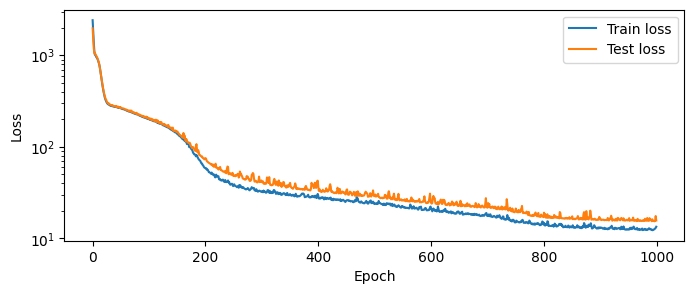

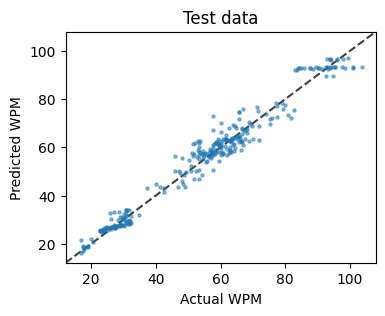

In [6]:
# Train/test loss
fig = plt.figure(figsize=(8, 3))
ax = plot.model_loss(train_loss, test_loss)
plt.show()

# Test: actual vs predicted wpm
y_pred = base_model(X_test)
fig = plt.figure(figsize=(4, 3))
ax = plot.model_scatter(y_test.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
ax.set_title("Test data")
plt.show()

## Hyperopt


In [7]:
# Define the space over which hyperopt will search for optimal hyperparameters.

# Final loss (MSE): 14.80364895
# Best optimized hyperparameters:
# {'gamma': 0.9995708178430882, 'learning_rate': 0.00874940256734166, 'log_interval': inf, 'weight_decay': 0.003608501354606639}
space = {
    # loguniform
    "learning_rate": hp.loguniform("learning_rate", np.log(0.0009), np.log(0.09)),
    "weight_decay": hp.loguniform("weight_decay", np.log(0.003), np.log(0.03)),
    "gamma": hp.uniform("gamma", 0.995, 0.99995),
    # Fixed
    "log_interval": np.inf,
}
max_evals = 25

# Final loss (MSE): 10.72558880
# Best optimized hyperparameters:
# {'batch_size': 4096, 'gamma': 0.9998522974475944, 'learning_rate': 0.003966298895429614, 'log_interval': inf, 'model': 'MLPcondensed', 'n_epochs': 10000, 'n_hidden_units': 64, 'n_layers': 1, 'weight_decay': 0.0023468805643251044}
space_large = {
    # loguniform
    "learning_rate": hp.loguniform("learning_rate", np.log(0.0005), np.log(0.9)),
    "weight_decay": hp.loguniform("weight_decay", np.log(0.00001), np.log(0.1)),
    "gamma": hp.uniform("gamma", 0.95, 0.99999),
    "n_hidden_units": hp.choice("n_hidden_units", [16, 64, 256, 1024]),
    "n_epochs": hp.choice("n_epochs", [1000, 10000]),
    "n_layers": hp.choice("n_layers", [1, 2, 3, 4, 5]),
    # Fixed
    # "n_epochs": 1000,
    "log_interval": np.inf,
    "batch_size": 4096,
}
max_evals_large = 300

In [8]:
def hyperparameter_tuning(space, verbose=True):
    """Define the hyperopt objective function."""
    # Set up the varied hyperparameters
    for key, value in space.items():
        if key in params.__dict__:
            setattr(params, key, value)

    # Create the model
    input_n = X.shape[1]
    output_n = y.shape[1]
    model = models.MLP(input_n, params.n_hidden_units, output_n, params.n_layers)
    model = model.to(params.device)

    # Set up for training
    optimizer = torch.optim.Adam(
        params=model.parameters(),
        lr=params.learning_rate,
        weight_decay=params.weight_decay,
    )
    scheduler = StepLR(optimizer, step_size=1, gamma=params.gamma)
    loss_function = nn.MSELoss()

    # Train model
    _, _ = models.train_and_evaluate(
        model, train_loader, test_loader, scheduler, optimizer, loss_function, params
    )
    model.eval()
    y_pred = model(X_test)
    loss = loss_function(y_pred, y_test)

    if verbose:
        print(f"Using varied parameters: {space}")
        print(f"                   Loss: {loss}")
    return {"loss": loss, "status": STATUS_OK, "model": model}

In [10]:
# Run trials.
run_large_space = False
if run_large_space:
    space_to_use = space_large
    max_evals_to_use = max_evals_large
else:
    space_to_use = space
    max_evals_to_use = max_evals
trials = Trials()
best = fmin(
    fn=hyperparameter_tuning,
    space=space_to_use,
    algo=tpe.suggest,
    max_evals=max_evals_to_use,
    trials=trials,
)
print(f"Best hyperparameters: {best}")

  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

Using varied parameters: {'gamma': 0.9954512000643995, 'learning_rate': 0.009139978605331073, 'log_interval': inf, 'weight_decay': 0.00829008916908376}
                   Loss: 15.400935173034668           
Using varied parameters: {'gamma': 0.9974862267497415, 'learning_rate': 0.012600413407323952, 'log_interval': inf, 'weight_decay': 0.012403738720236592}
                   Loss: 14.75                                                  
Using varied parameters: {'gamma': 0.9958494375881694, 'learning_rate': 0.01971742952595554, 'log_interval': inf, 'weight_decay': 0.017609519119230813}
                   Loss: 15.677520751953125                        
Using varied parameters: {'gamma': 0.9956995557275957, 'learning_rate': 0.07033617376126414, 'log_interval': inf, 'weight_decay': 0.004634646935236465}
                   Loss: 17.459457397460938                        
Using varied parameters: {'gamma': 0.9979156657275761, 'learning_rate': 0.0012770826725969316, 'log_interval': inf, 'we

In [ ]:
# Create instace of best model.
best_model = trials.results[np.argmin([r["loss"] for r in trials.results])]["model"]

# Examine model hyperparameters
best_model_loss = trials.results[np.argmin([r["loss"] for r in trials.results])]["loss"]
print(f"Final loss (MSE): {best_model_loss:.8f}")
print(f"Best optimized hyperparameters:\n{space_eval(space, best)}")

Final loss (MSE): 14.80364895
Best optimized hyperparameters:
{'gamma': 0.9995708178430882, 'learning_rate': 0.00874940256734166, 'log_interval': inf, 'weight_decay': 0.003608501354606639}


In [ ]:
best_model.eval()
best_model_score = root_mean_squared_error(
    y_test.cpu(), best_model(X_test).cpu().detach().numpy()
)
print("Best Model RMSE:", best_model_score)
#
base_model_score = root_mean_squared_error(
    y_test.cpu(), base_model(X_test).cpu().detach().numpy()
)
print("Base model RMSE:", base_model_score)
# MSE from guessing the mean of the training set
mean_model_score = root_mean_squared_error(
    y_test.cpu(), np.full(y_test.shape, np.mean(y_train.cpu().detach().numpy()))
)
print("Mean model RMSE:", mean_model_score)

Best Model RMSE: 3.847551
Base model RMSE: 3.9647524
Mean model RMSE: 21.851515


## Save Trials and plot results


In [ ]:
# Save all the trials to a file with name append datetime
# Save the trials object
# TODO fix save location, add option to load and plot, maybe in another notebook
if run_large_space:
    trial_filename = f"trials_{time.strftime('%Y%m%d-%H%M%S')}.pkl"
    trial_filepath = models.MODEL_PATH / trial_filename
    print(trial_filepath)
    with open(trial_filepath, "wb") as f:
        pickle.dump(trials, f)

best loss: 14.803648948669434


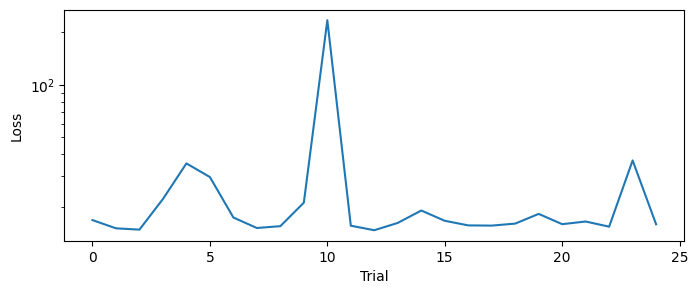

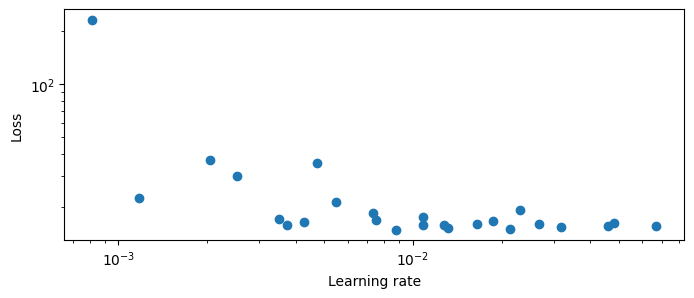

In [ ]:
# Plot basic results from Trials
# Extract the losses from the trials object
losses = [x["result"]["loss"] for x in trials.trials]
learning_rates = [x["misc"]["vals"]["learning_rate"] for x in trials.trials]
best_loss = np.min(losses)
print(f"best loss: {best_loss}")
# Plot loss across trials
fig = plt.figure(figsize=(8, 3))
plt.plot(losses)
plt.xlabel("Trial")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()
# Plot losses as function of learning rate
fig = plt.figure(figsize=(8, 3))
plt.scatter(learning_rates, losses)
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.yscale("log")
plt.xscale("log")
plt.show()

In [ ]:
def unpack(x):
    if x:
        return x[0]
    return np.nan


# We'll first turn each trial into a series and then stack those series together as a dataframe.
trials_df = pd.DataFrame([pd.Series(t["misc"]["vals"]).apply(unpack) for t in trials])
# Then we'll add other relevant bits of information to the correct rows and perform a couple of
# mappings for convenience
trials_df["loss"] = [t["result"]["loss"] for t in trials]
trials_df["trial_number"] = trials_df.index
trials_df.head()

,gamma,learning_rate,weight_decay,loss,trial_number
0,0.997670,0.003512,0.001082,16.913649,0
1,0.996151,0.013157,0.000115,15.176113,1
2,0.994527,0.021322,0.000178,14.919141,2
3,0.997337,0.001179,0.000108,22.292828,3
4,0.991973,0.004721,0.005191,35.573280,4


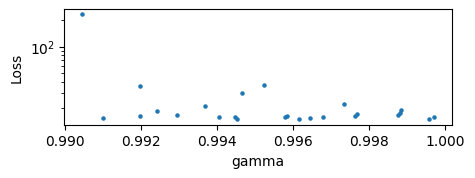

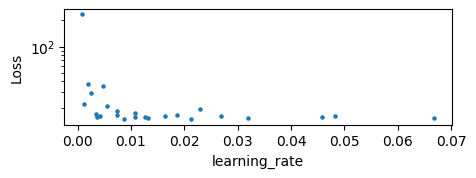

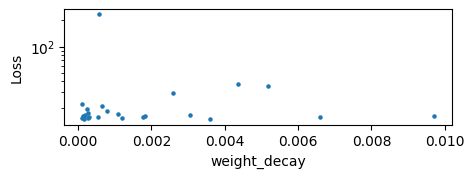

In [ ]:
# Loop over columns of the dataframe and plot loss vs hyperparameter
for col in trials_df.columns:
    if col in ["loss", "trial_number"]:
        continue
    fig = plt.figure(figsize=(5, 1.5))
    plt.scatter(trials_df[col], trials_df["loss"], s=5)
    plt.xlabel(col)
    plt.ylabel("Loss")
    plt.yscale("log")
    plt.show()